<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/PyTorch_Video_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

## Setup

To save us time, we are going to leverage some of the scripts we previously developed such as `data_setup.py` and `engine.py`.

We will also get the `torchinfo` package which is helpful for creating a visual representation of our model

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision.transforms import v2

try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

In [2]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 4036 (delta 1069), reused 1087 (delta 998), pack-reused 2812
Receiving objects: 100% (4036/4036), 650.87 MiB | 54.24 MiB/s, done.
Resolving deltas: 100% (2362/2362), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Getting Data

Lets get a dataset

In [4]:
from pathlib import Path
import os
import zipfile
import requests

data_path = Path("data/")
image_path = data_path / "images"

# Check if directory exists

if image_path.is_dir():
  print("Directory already exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path/"images.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "images.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

  os.remove(data_path / "images.zip")

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create DataLoaders

In the older version of torchvision we would have to manually create transforms for our custom data. It is important that the data going into the model is prepared in the same way as the original raining data.

1. Mini Batches of size [3, 224, 244]
2. Tensors with values between 0 and 1
3. A mean of [0.485, 0.456, 0.406 ]
4. A standard deviation of [ 0.229, 0.224, 0.225]


In [6]:
manual_transform = v2.Compose([v2.Resize((224,224), antialias=True),
                               v2.PILToTensor(),
                               v2.Normalize(mean=[0.485, 0.456, 0.406],
                                            std = [0.229, 0.224, 0.225])])

However, in newerversions of torch an automatic transform creation feature has been added.

We can acquire a pretrained model from `torchvision.models` then find the associated transform used for the particular model we choose.

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

`EfficientNet_B0_Weights` is the model architecture weights we'd like to use. Selecting DEFAULT means we are choosing the best available weights.

To access the transforms associated with our weights we can use the `transform()` method.

In [8]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, auto_transform, batch_size=32)

## Getting a Pretrained Model

Choosing the right model depends on the problem/device you are working on. The higher the number in the model name usually suggests a better performing model, but the tradeoff is computation requirements and size.

Hence, if you are running a model a mobile device, you may opt to go for a smaller model.

We are going to be using the `torchivision.models.efficientnet_b0()`, which is the same one we used to extract our transform function. This model achieves 77% accuracy across ImageNet's 1000 different classes.

In [10]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict


weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


The Efficient Net Models comes in three main parts

1. `features` - A collection of convolution layers and other various activiation layers to learn a base representation of vision data
2. `avgpool` - Takes the average of the output of the `features` alayer and turns it into a **feature vector**
3. `classifier` - Turns the **feature vector** into a vectorwith the same dimensionality as the number of required output classes

## Getting a Model Summary

To learn more about our model we can use `torchinfo.summary()` where we pass in

1. `model` - The Model
2. `input_size` - Shape of data we'd pass our model
3. `col_names` - The various information columns we'd like to see about our model
4. `col_width` - How wide the coluwmns should be for summary
5. `row_setting` - What features to show in rows

In [11]:
summary(model, (32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Feezing Layers and Modfiying Model

We can freeze the layers/parameters in the feature section by setting the `requires_grad` to False. PyTorch doesn't track gradient updates and in turn, these parameters won't change during training.

In [12]:
for param in model.features.parameters():
  param.requires_grad = False

Next we can modify the classifyer block to suit our needs. We can keep the dropout layer, but we need to modify to Linear layer to predict for 3 classes rather than 1000.

*Dropput Layer* - Randomly remove connectiosn between two neural network layers wit ha probability of `p`. For example if `p = 0.2` then 20% of the nodes between NN layers will be removed at random each pass.

This is to help regularize a model with many features.



In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [14]:
summary(model, (32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

**Trainable** - This column specifies whether certain features can have the weights vector modified. Notice how all the layers in the features are set to False.

**Output Shape of Classifier** - The output shape is [32,3] which indicates it is predicting between 3 different classes.

**Less Trainable Parameters** - Previously there were over 5 milion trainable parameters but now there are only 3.8k

Freezing base layers, means there are less trainable parameters, but then also in turn increases the training speed of our model since there are less computations to be done.

## Train Model

Lets try training the model

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)


In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()

print(f"Time Taken: {(end_time - start_time):.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Time Taken: 8.12


## Plot Loss Curves

Lets take a look at what training over time is like

In [17]:
device

'cuda'

In [18]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Text(0.5, 1.0, 'Accuracy')

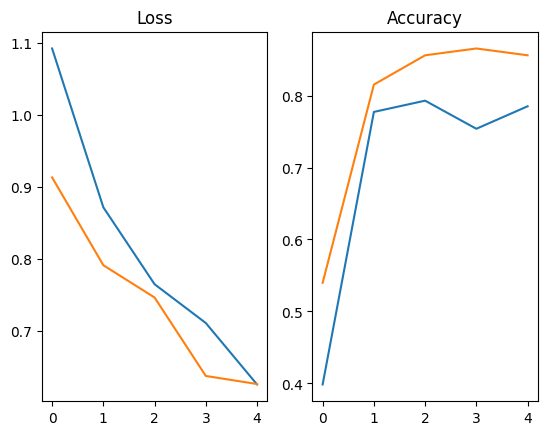

In [19]:
fig, ax = plt.subplots(1,2)

ax[0].plot(results["train_loss"])
ax[0].plot(results["test_loss"])
ax[0].set_title("Loss")

ax[1].plot(results["train_acc"])
ax[1].plot(results["test_acc"])
ax[1].set_title("Accuracy")

## Making Predictiosn on Test Set

Visualize the Image and Show the model's preditions vs. true label. In order to do so, we need to make sure the images have:

* Same Shape - Need to ensure images are the same shape as what our model was trained on
* Same Datatype - `torch.int8` vs `torch.float32`
* Same device - Ensure image and model on same device
* Same Transformations - Ensure images have same transformations as training set

In [29]:
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot(model, images, class_names, transform, device):

  model.to(device)
  plt.figure(figsize=(8,12))

  # Open the image
  for index, image in enumerate(images):
    img = Image.open(image)
    transformed_img = transform(img).unsqueeze(dim=0).to(device)

    model.eval()
    with torch.inference_mode():
      # Get prediction
      image_pred = class_names[model(transformed_img).softmax(dim=1).argmax(dim=1)]

    # Plot the Image
    plt.subplot(len(images), 1, index + 1)
    plt.imshow(img)
    plt.title(image_pred)



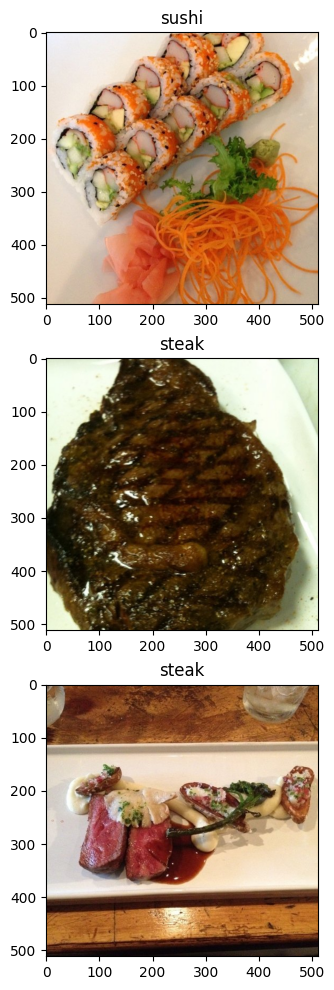

In [34]:
import random

image_list = list(Path(test_dir).glob("*/*.jpg"))
images = random.sample(image_list, 3)


pred_and_plot(model, images, class_names, auto_transform, device)


## Predictions on Custom ImagesMM

In [35]:
from google.colab import files

uploaded_img = files.upload()

Saving sushi.jpg to sushi.jpg


In [40]:
img = Image.open("sushi.jpg")

In [50]:
transformed_uploaded_img=auto_transform(img).unsqueeze(0)
transformed_uploaded_img.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'sushi')

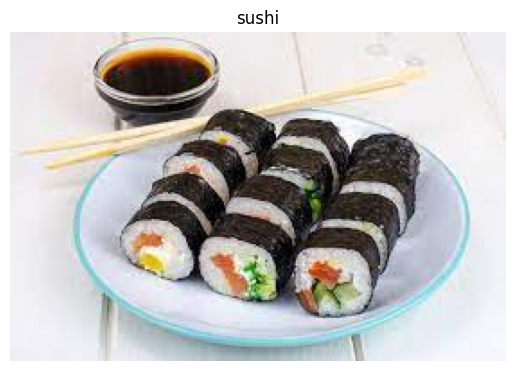

In [54]:
model.eval()
with torch.inference_mode():
  y_pred = model(transformed_uploaded_img.to(device)).softmax(dim=1).argmax(dim=1)

prediction = class_names[y_pred]

plt.imshow(img)
plt.axis(False)
plt.title(prediction)

## Takeaways

- Transfer Learning allows you to get good results with relatively small amount of custom data
- Good idea to ask "Does an existing well-performing model exist?"
- Important your custom data be formatted in the same way that the original model was trained on
- Rememeber the different places to find pre-trained models